Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.0.2

torch: 2.6.0+cu126



# ResNet-34 QuickDraw Classifier

### Network Architecture

The network in this notebook is an implementation of the ResNet-34 [1] architecture on the MNIST digits dataset (http://yann.lecun.com/exdb/mnist/) to train a handwritten digit classifier.  
本笔记本中的网络是 ResNet-34 [1] 架构在 MNIST 手写数字数据集（http://yann.lecun.com/exdb/mnist/）上的实现，用于训练一个手写数字分类器。

References  
参考文献

- [1] He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778). ([CVPR Link](https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html))  
- [1] He, K., Zhang, X., Ren, S., & Sun, J.（2016）。用于图像识别的深度残差学习。发表于 IEEE 计算机视觉与模式识别会议论文集（第770-778页）。([CVPR链接](https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html))

- [2] http://yann.lecun.com/exdb/mnist/  

![](../images/resnets/resnet34/resnet34-arch.png)

The following figure illustrates residual blocks with skip connections such that the input passed via the shortcut matches the dimensions of the main path's output, which allows the network to learn identity functions.  
下图展示了具有跳跃连接的残差块，其中通过快捷路径传递的输入与主路径输出的维度相匹配，这使得网络可以学习恒等映射函数。

![](../images/resnets/resnet-ex-1-1.png)  

The ResNet-34 architecture actually uses residual blocks with skip connections such that the input passed via the shortcut matches is resized to dimensions of the main path's output. Such a residual block is illustrated below:  
ResNet-34 架构实际上使用的是这样的残差块：跳跃连接中的输入会被调整尺寸，以匹配主路径的输出维度。如下图所示：

![](../images/resnets/resnet-ex-1-2.png)  

For a more detailed explanation see the other notebook, [resnet-ex-1.ipynb](resnet-ex-1.ipynb).

## Imports

In [2]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.cuda.set_per_process_memory_fraction(0.5, device=0)
    torch.backends.cudnn.deterministic = True

## Model Settings

In [3]:
##########################
### 设置参数
##########################

# 超参数（Hyperparameters）
RANDOM_SEED = 1          # 随机种子，保证实验可复现
LEARNING_RATE = 0.001    # 学习率
BATCH_SIZE = 128         # 每个批次的样本数量
NUM_EPOCHS = 10          # 训练轮数（Epoch数量）

# 网络结构相关参数（Architecture）
NUM_FEATURES = 28*28     # 输入特征维度（例如用于MNIST 28x28图像）
NUM_CLASSES = 10         # 输出类别数量（例如MNIST共10类数字）

# 其他设置（Other）
DEVICE = "cuda:0"        # 训练设备（使用GPU0进行加速）
GRAYSCALE = True         # 是否为灰度图像（MNIST为True，RGB图像为False）

## Dataset

This notebook is based on Google's Quickdraw dataset (https://quickdraw.withgoogle.com).  
本笔记本基于 Google 的 Quickdraw 数据集 https://quickdraw.withgoogle.com 。

In particular we will be working with an arbitrary subset of 10 categories in png format:  
我们将使用其中任意选择的10个类别的 PNG 图像子集：

```python
label_dict = {
     "lollipop": 0,
     "binoculars": 1,
     "mouse": 2,
     "basket": 3,
     "penguin": 4,
     "washing machine": 5,
     "canoe": 6,
     "eyeglasses": 7,
     "beach": 8,
     "screwdriver": 9,
}
```

(The class labels 0-9 can be ignored in this notebook).  
（本笔记本中可以忽略这些类别标签0-9。）

For more details on obtaining and preparing the dataset, please see the  
有关如何获取和准备数据集的更多详细信息，请参见：
- [custom-data-loader-quickdraw.ipynb](custom-data-loader-quickdraw.ipynb)

(28, 28)


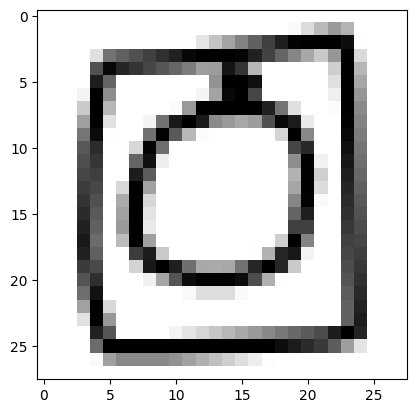

In [4]:
df = pd.read_csv('quickdraw_png_set1_train.csv', index_col=0)
df.head()

main_dir = 'quickdraw-png_set1/'

img = Image.open(os.path.join(main_dir, df.index[99]))
img = np.asarray(img, dtype=np.uint8)
print(img.shape)
plt.imshow(np.array(img), cmap='binary')
plt.show()

### Create a Custom Data Loader

In [5]:
class QuickdrawDataset(Dataset):
    """自定义数据集类，用于加载Quickdraw图像"""

    def __init__(self, txt_path, img_dir, transform=None):
        # 读取图像标签信息（CSV文件），第一列为文件名索引
        df = pd.read_csv(txt_path, sep=",", index_col=0)
        self.img_dir = img_dir              # 图像文件夹路径
        self.txt_path = txt_path            # 标签文件路径
        self.img_names = df.index.values    # 图像文件名列表
        self.y = df['Label'].values         # 图像对应的标签
        self.transform = transform          # 图像变换（如Tensor转换、增强等）

    def __getitem__(self, index):
        # 加载索引对应的图像
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))

        # 如果指定了transform（如ToTensor、Normalize等），则进行处理
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]  # 获取对应的标签
        return img, label      # 返回图像和标签

    def __len__(self):
        # 返回数据集中图像的总数量
        return self.y.shape[0]


In [6]:
# 注意：transforms.ToTensor() 会自动将像素值除以255，归一化到[0,1]范围内

BATCH_SIZE = 128  # 每个批次的数据量

# 图像预处理操作（这里仅使用了ToTensor，可根据需要添加更多变换）
custom_transform = transforms.Compose([
    # transforms.Lambda(lambda x: x/255.),  # 无需手动除以255，ToTensor已处理
    transforms.ToTensor()
])

# 加载训练集
train_dataset = QuickdrawDataset(
    txt_path='quickdraw_png_set1_train.csv',     # 标签CSV文件路径
    img_dir='quickdraw-png_set1/',               # 图像文件所在文件夹
    transform=custom_transform                   # 应用的图像预处理
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,         # 打乱数据顺序
    num_workers=4         # 使用4个子进程加载数据
)

# 加载验证集
valid_dataset = QuickdrawDataset(
    txt_path='quickdraw_png_set1_valid.csv',
    img_dir='quickdraw-png_set1/',
    transform=custom_transform
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,        # 验证集不打乱顺序
    num_workers=4
)

# 加载测试集
test_dataset = QuickdrawDataset(
    txt_path='quickdraw_png_set1_test.csv',
    img_dir='quickdraw-png_set1/',
    transform=custom_transform
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,        # 测试集不打乱顺序
    num_workers=4
)


In [7]:
device = torch.device(DEVICE if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128


## Model

The following code cell that implements the ResNet-34 architecture is a derivative of the code provided at https://pytorch.org/docs/0.4.0/_modules/torchvision/models/resnet.html.

In [8]:
##########################
### 模型定义
##########################

def conv3x3(in_planes, out_planes, stride=1):
    """带padding的3x3卷积层"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1  # 通道扩展倍数（BasicBlock为1）

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        # 第一层卷积
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        # 第二层卷积
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        # 是否进行下采样（用于残差连接对齐维度）
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x  # 残差连接的输入（shortcut）

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # 如果需要下采样，则对residual进行变换
        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual  # 残差连接
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64  # 初始通道数
        # 灰度图像通道为1，RGB图像为3
        in_dim = 1 if grayscale else 3

        super(ResNet, self).__init__()
        # 输入图像的第一层卷积
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # 构建4个残差层，每层包含若干BasicBlock
        self.layer1 = self._make_layer(block, 64, layers[0])     # 输出通道64
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)  # 输出通道128
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)  # 输出通道256
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)  # 输出通道512

        # 平均池化层（默认不启用，适配MNIST等小图像）
        self.avgpool = nn.AvgPool2d(7, stride=1)
        # 全连接层用于分类（输入特征 = 512）
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # 初始化所有卷积层和BN层参数
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**0.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        """
        构建一个残差层，由多个BasicBlock组成
        """
        downsample = None
        # 如果输入输出维度不一致或stride不为1，则使用下采样对齐残差
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        # 第一个block可能包含下采样
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        # 后续blocks保持维度一致
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        # 输入图像通过初始卷积、BN、ReLU、池化
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # 依次通过四个残差层
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # 对于小尺寸图像（如MNIST），可跳过平均池化
        # x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)       # 展平为一维向量
        logits = self.fc(x)             # 全连接层输出分类结果
        probas = F.softmax(logits, dim=1)  # 计算概率分布
        return logits, probas


def resnet34(num_classes):
    """构建 ResNet-34 模型"""
    model = ResNet(block=BasicBlock, 
                   layers=[3, 4, 6, 3],           # 每个阶段的block数量（ResNet-34结构）
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

In [9]:
torch.manual_seed(RANDOM_SEED)
model = resnet34(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

## Training

In [10]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0  # 初始化正确预测的数量和总样本数
    for i, (features, targets) in enumerate(data_loader):  # 遍历数据加载器中的每个批次
        features = features.to(device)  # 将特征移到指定设备
        targets = targets.to(device)  # 将标签移到指定设备

        logits, probas = model(features)  # 前向传播，得到logits和预测概率
        _, predicted_labels = torch.max(probas, 1)  # 获取概率最大的类别
        num_examples += targets.size(0)  # 增加批次中的样本数
        correct_pred += (predicted_labels == targets).sum()  # 计算正确预测的数量
    # 返回准确率（百分比），使用float()转换为浮点数
    return correct_pred.float()/num_examples * 100  


start_time = time.time()  # 记录训练开始时间
for epoch in range(NUM_EPOCHS):  # 遍历所有训练轮次
    
    model.train()  # 设置模型为训练模式
    for batch_idx, (features, targets) in enumerate(train_loader):  # 遍历训练数据
        features = features.to(DEVICE)  # 将特征移到指定设备
        targets = targets.to(DEVICE)  # 将标签移到指定设备
            
        ### 正向传播和反向传播
        logits, probas = model(features)  # 前向传播，得到logits和预测概率
        cost = F.cross_entropy(logits, targets)  # 计算交叉熵损失
        optimizer.zero_grad()  # 清空之前的梯度
        
        cost.backward()  # 反向传播，计算梯度
        
        ### 更新模型参数
        optimizer.step()  # 更新模型参数
        
        ### 记录日志
        if not batch_idx % 50:  # 每50个批次打印一次日志
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))

    # 设置模型为评估模式，以防在推理过程中更新批归一化参数
    model.eval()  
    with torch.set_grad_enabled(False):  # 在推理过程中禁用梯度计算，节省内存
        # 打印训练集上的准确率
        print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(model, train_loader, device=DEVICE)))  

    # 打印已用时间，单位：分钟
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))  
    
# 打印总训练时间，单位：分钟
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))  


Epoch: 001/010 | Batch 0000/0391 | Cost: 2.6929
Epoch: 001/010 | Batch 0050/0391 | Cost: 0.5978
Epoch: 001/010 | Batch 0100/0391 | Cost: 0.6248
Epoch: 001/010 | Batch 0150/0391 | Cost: 0.5486
Epoch: 001/010 | Batch 0200/0391 | Cost: 0.3570
Epoch: 001/010 | Batch 0250/0391 | Cost: 0.4750
Epoch: 001/010 | Batch 0300/0391 | Cost: 0.4612
Epoch: 001/010 | Batch 0350/0391 | Cost: 0.3723
Epoch: 001/010 | Train: 86.746%
Time elapsed: 0.54 min
Epoch: 002/010 | Batch 0000/0391 | Cost: 0.5986
Epoch: 002/010 | Batch 0050/0391 | Cost: 0.3201
Epoch: 002/010 | Batch 0100/0391 | Cost: 0.3323
Epoch: 002/010 | Batch 0150/0391 | Cost: 0.4868
Epoch: 002/010 | Batch 0200/0391 | Cost: 0.4517
Epoch: 002/010 | Batch 0250/0391 | Cost: 0.3907
Epoch: 002/010 | Batch 0300/0391 | Cost: 0.3273
Epoch: 002/010 | Batch 0350/0391 | Cost: 0.3549
Epoch: 002/010 | Train: 89.732%
Time elapsed: 1.07 min
Epoch: 003/010 | Batch 0000/0391 | Cost: 0.3395
Epoch: 003/010 | Batch 0050/0391 | Cost: 0.2999
Epoch: 003/010 | Batch 010

## Evaluation

In [11]:
with torch.set_grad_enabled(False): # 在推理过程中禁用梯度计算，节省内存
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

Test accuracy: 90.42%


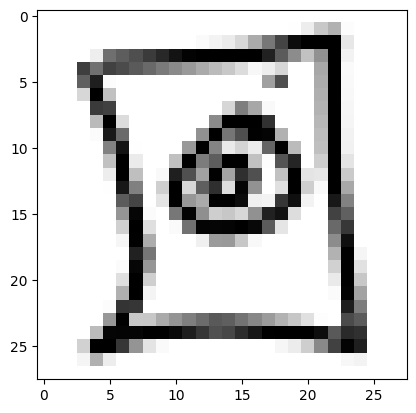

In [12]:
for batch_idx, (features, targets) in enumerate(test_loader):
    # 获取该 batch 中所有 label=5 的样本索引
    indices = (targets == 5).nonzero(as_tuple=True)[0]

    if len(indices) > 0:
        # ✅ 提取所有 label=5 的样本
        imgs_5 = features[indices]     # shape: [N, C, H, W]
        labels_5 = targets[indices]    # 全是 5

nhwc_img = np.transpose(imgs_5[5], axes=(1, 2, 0))
nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)
plt.imshow(nhw_img, cmap='Greys');

In [13]:
model.eval()
logits, probas = model(imgs_5[0].unsqueeze(0).to(device))
print('Probability Washing Machine %.2f%%' % (probas[0][5]*100))

Probability Washing Machine 100.00%


In [14]:
%watermark -iv

numpy      : 1.26.4
torch      : 2.6.0+cu126
torchvision: 0.21.0+cu126
pandas     : 2.2.3
matplotlib : 3.10.1
PIL        : 11.1.0

